In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

CSV_PATH = Path("data/biroylikgarovlilar.csv")  # <-- change if needed
REPORTS_DIR = Path("reports"); REPORTS_DIR.mkdir(exist_ok=True)

df = pd.read_csv(CSV_PATH)  # no cleanup, raw load
df.shape, df.head(3)


((492, 19),
    Unnamed: 0       Код                           Наименование           Облать     Город/район Облать(Фактичекий адрес)        Номер        Дата  \
 0          29  99224744        RAXIMOVA QIMMATXON SULAYMONOVNA  АНДИЖОН ВИЛОЯТИ    АСАКА ТУМАНИ          АНДИЖОН ВИЛОЯТИ  02-1468/25K  01.08.2025   
 1          38  99224753         NAZAROVA MUXABBAT BAYNAZAROVNA  АНДИЖОН ВИЛОЯТИ  АНДИЖОН ТУМАНИ          АНДИЖОН ВИЛОЯТИ  02-1469/25K  01.08.2025   
 2          44  99137961  Komilov Muxammad Ali Baxriddin o’g’li  АНДИЖОН ВИЛОЯТИ    АСАКА ТУМАНИ          АНДИЖОН ВИЛОЯТИ  02-1470/25K  01.08.2025   
 
            Сумма  % ставка         Наименование.1 Наименование.2                  Тип Гос.номер   Марка Тип кузова                       Цвет  Год выпуска  \
 0  30,000,000.00      48.0  Транспортные средства         MALIBU  Легковые автомобили  60B960AB  MALIBU      SEDAN          ОЛИМПИЙСКИЙ БЕЛЫЙ         2012   
 1  30,000,000.00      48.0  Транспортные средства         COBALT  Л

In [3]:
print("Rows, Cols:", df.shape)
print("\nColumn names:\n", list(df.columns))

print("\nDtypes:")
print(df.dtypes)

mem_mb = df.memory_usage(deep=True).sum() / 1_048_576
print(f"\nMemory usage: {mem_mb:.2f} MB")


Rows, Cols: (492, 19)

Column names:
 ['Unnamed: 0', 'Код', 'Наименование', 'Облать', 'Город/район', 'Облать(Фактичекий адрес)', 'Номер', 'Дата', 'Сумма', '% ставка', 'Наименование.1', 'Наименование.2', 'Тип', 'Гос.номер', 'Марка', 'Тип кузова', 'Цвет', 'Год выпуска', 'Страна производитель']

Dtypes:
Unnamed: 0                    int64
Код                           int64
Наименование                 object
Облать                       object
Город/район                  object
Облать(Фактичекий адрес)     object
Номер                        object
Дата                         object
Сумма                        object
% ставка                    float64
Наименование.1               object
Наименование.2               object
Тип                          object
Гос.номер                    object
Марка                        object
Тип кузова                   object
Цвет                         object
Год выпуска                   int64
Страна производитель         object
dtype: object


In [4]:
missing = pd.DataFrame({
    "missing_count": df.isna().sum(),
    "missing_pct": (df.isna().mean() * 100).round(2),
    "dtype": df.dtypes.astype(str),
}).sort_values("missing_pct", ascending=False)
missing.head(30)


,missing_count,missing_pct,dtype
Unnamed: 0,0,0.0,int64
Код,0,0.0,int64
Наименование,0,0.0,object
Облать,0,0.0,object
Город/район,0,0.0,object
Облать(Фактичекий адрес),0,0.0,object
Номер,0,0.0,object
Дата,0,0.0,object
Сумма,0,0.0,object
% ставка,0,0.0,float64


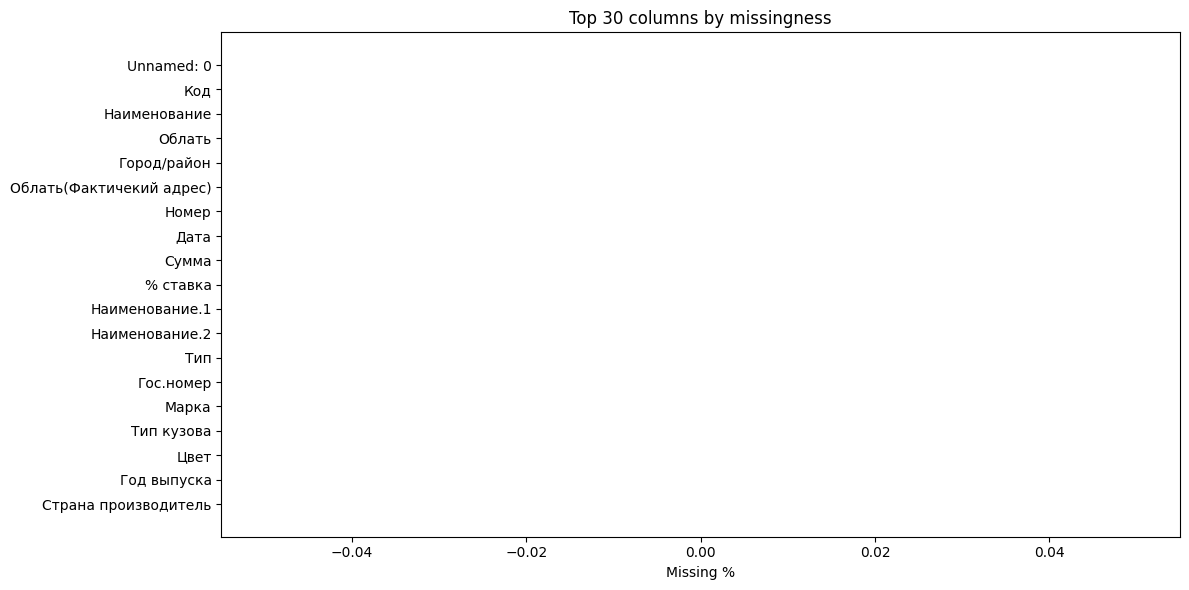

In [5]:
N = 30
ms = missing.head(N)

plt.figure(figsize=(12, 6))
plt.barh(ms.index[::-1], ms["missing_pct"][::-1])
plt.xlabel("Missing %")
plt.title(f"Top {N} columns by missingness")
plt.tight_layout()
plt.savefig(REPORTS_DIR / "missingness_top.png", dpi=150)
plt.show()


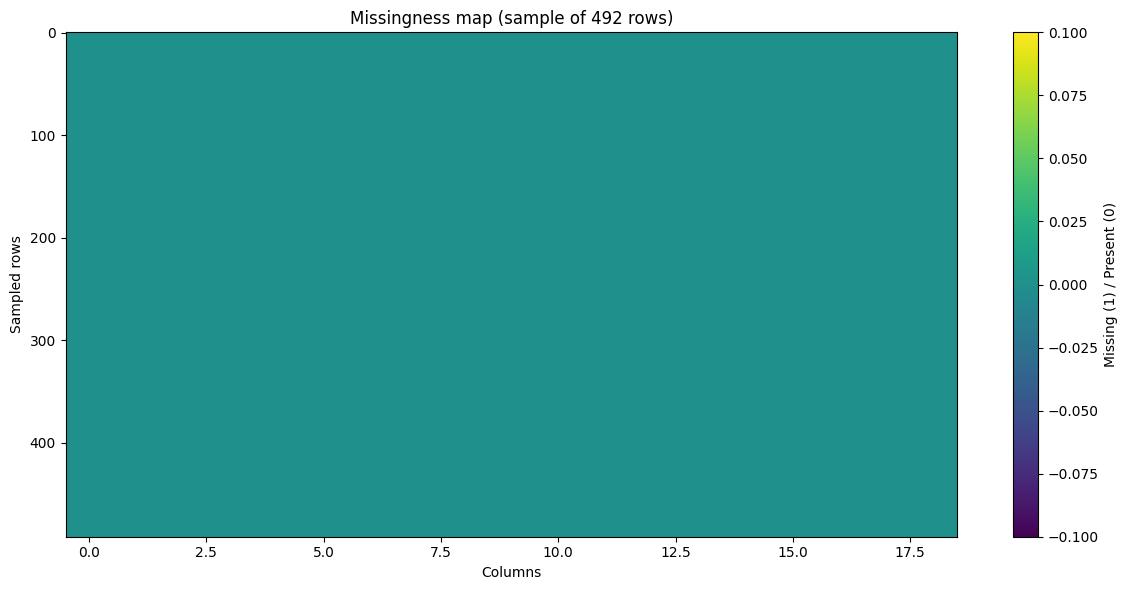

In [6]:
sample_n = min(500, len(df))
sample = df.sample(sample_n, random_state=42)
mat = sample.isna().to_numpy().astype(int)  # 1 = missing, 0 = present

plt.figure(figsize=(12, 6))
plt.imshow(mat, aspect="auto", interpolation="nearest")
plt.colorbar(label="Missing (1) / Present (0)")
plt.title(f"Missingness map (sample of {sample_n} rows)")
plt.xlabel("Columns"); plt.ylabel("Sampled rows")
plt.tight_layout()
plt.savefig(REPORTS_DIR / "missingness_map.png", dpi=150)
plt.show()


In [7]:
def as_numeric(s: pd.Series) -> pd.Series:
    x = s.astype(str)
    x = (x.str.replace("\xa0", "", regex=False)
           .str.replace(" ", "", regex=False)
           .str.replace("\u2009", "", regex=False)
           .str.replace(",", ".", regex=False)
           .str.replace("\u2212", "-", regex=False))
    return pd.to_numeric(x, errors="coerce")

def detect_numeric_cols(df, thresh=0.6):
    out = []
    for c in df.columns:
        try:
            conv = as_numeric(df[c])
            if conv.notna().mean() >= thresh:
                out.append(c)
        except Exception:
            pass
    return out

def detect_date_cols(df, thresh=0.6):
    out = []
    for c in df.columns:
        try:
            sample = df[c].dropna().astype(str).head(200)
            if sample.empty: 
                continue
            parsed = pd.to_datetime(sample, errors="coerce", dayfirst=True, infer_datetime_format=True)
            if parsed.notna().mean() >= thresh:
                out.append(c)
        except Exception:
            pass
    return out

num_cols  = detect_numeric_cols(df)
date_cols = detect_date_cols(df)

print("Detected numeric-like columns:", num_cols[:20], "..." if len(num_cols)>20 else "")
print("Detected date-like columns:", date_cols)


Detected numeric-like columns: ['Unnamed: 0', 'Код', '% ставка', 'Год выпуска'] 
Detected date-like columns: ['Дата', 'Год выпуска']


/tmp/ipykernel_91736/672199286.py:28: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(sample, errors="coerce", dayfirst=True, infer_datetime_format=True)
/tmp/ipykernel_91736/672199286.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(sample, errors="coerce", dayfirst=True, infer_datetime_format=True)
/tmp/ipykernel_91736/672199286.py:28: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove thi

In [8]:
desc = {}
for c in num_cols:
    conv = as_numeric(df[c])
    desc[c] = conv.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99])
numeric_summary = pd.DataFrame(desc).T
numeric_summary.head(20)


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Unnamed: 0,492.0,4.811087e+03,2697.524525,29.0,118.55,447.55,2491.25,4893.0,7205.00,8880.45,9221.16,9372.0
Код,492.0,9.917686e+07,72473.614976,99000573.0,99006582.29,99038907.65,99118587.50,99225854.0,99229732.25,99232848.60,99233342.08,99233503.0
% ставка,492.0,4.702439e+01,2.216264,42.0,42.00,42.00,48.00,48.0,48.00,48.00,48.00,48.0
Год выпуска,492.0,2.015037e+03,5.209920,1996.0,2003.91,2007.00,2011.00,2014.0,2019.00,2024.00,2025.00,2025.0


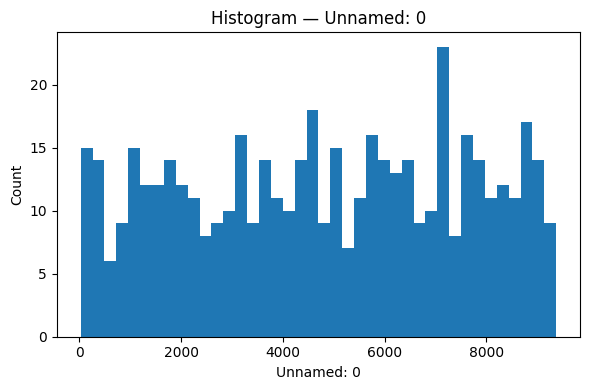

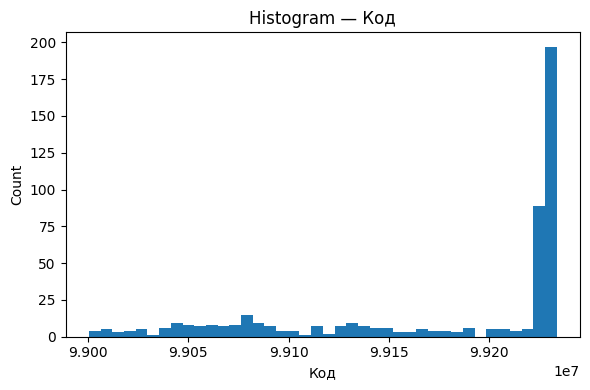

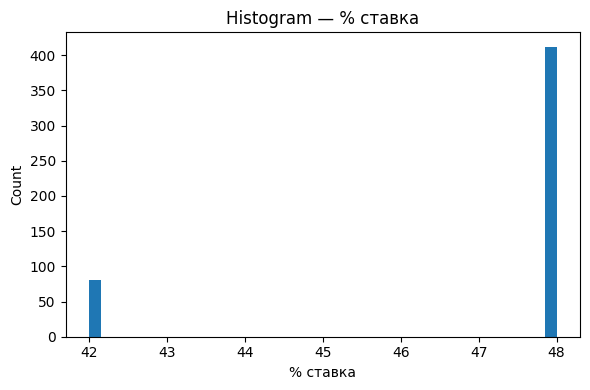

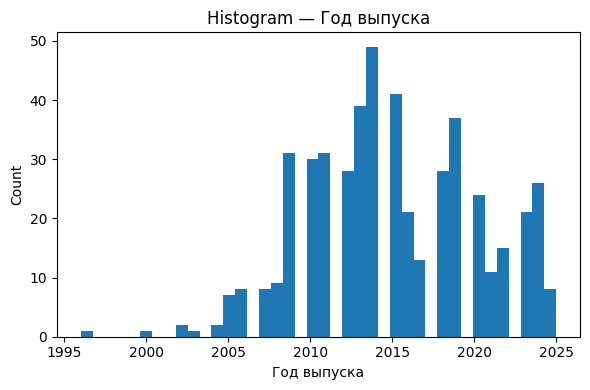

In [9]:
max_plots = 12  # avoid huge output; increase if you want
for i, c in enumerate(num_cols[:max_plots], 1):
    plt.figure(figsize=(6, 4))
    conv = as_numeric(df[c]).dropna()
    plt.hist(conv, bins=40)
    plt.title(f"Histogram — {c}")
    plt.xlabel(c); plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / f"hist_{i:02d}_{c}.png", dpi=120)
    plt.show()


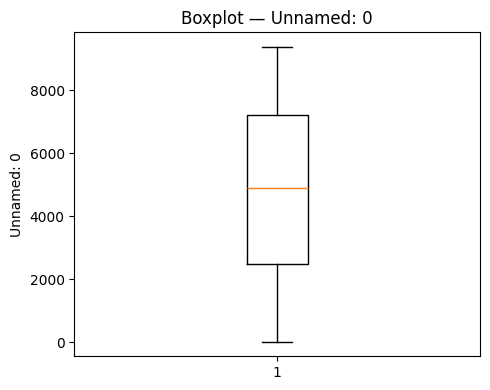

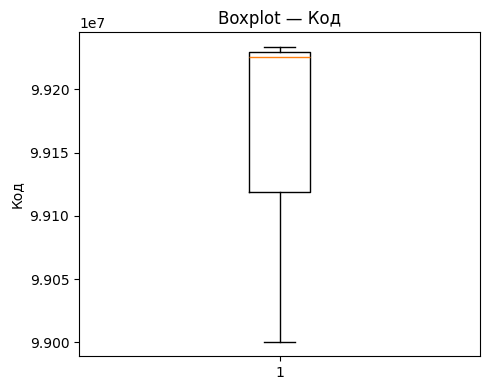

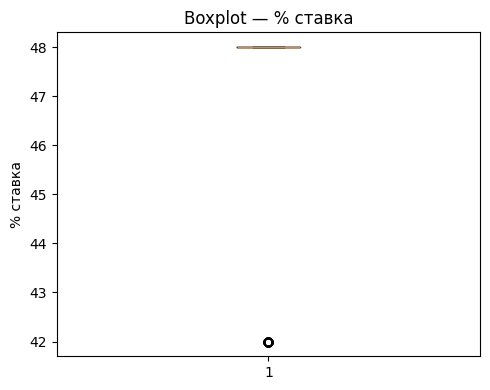

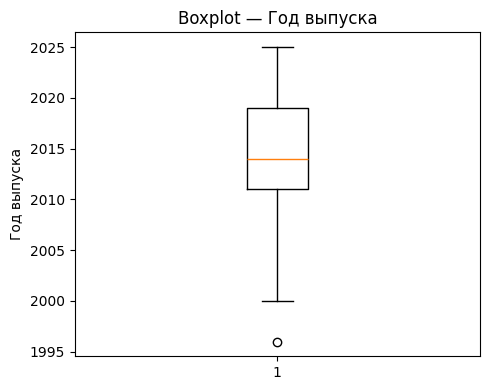

In [10]:
max_plots = 12
for i, c in enumerate(num_cols[:max_plots], 1):
    plt.figure(figsize=(5, 4))
    conv = as_numeric(df[c]).dropna()
    plt.boxplot(conv, vert=True, whis=1.5)
    plt.title(f"Boxplot — {c}")
    plt.ylabel(c)
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / f"box_{i:02d}_{c}.png", dpi=120)
    plt.show()


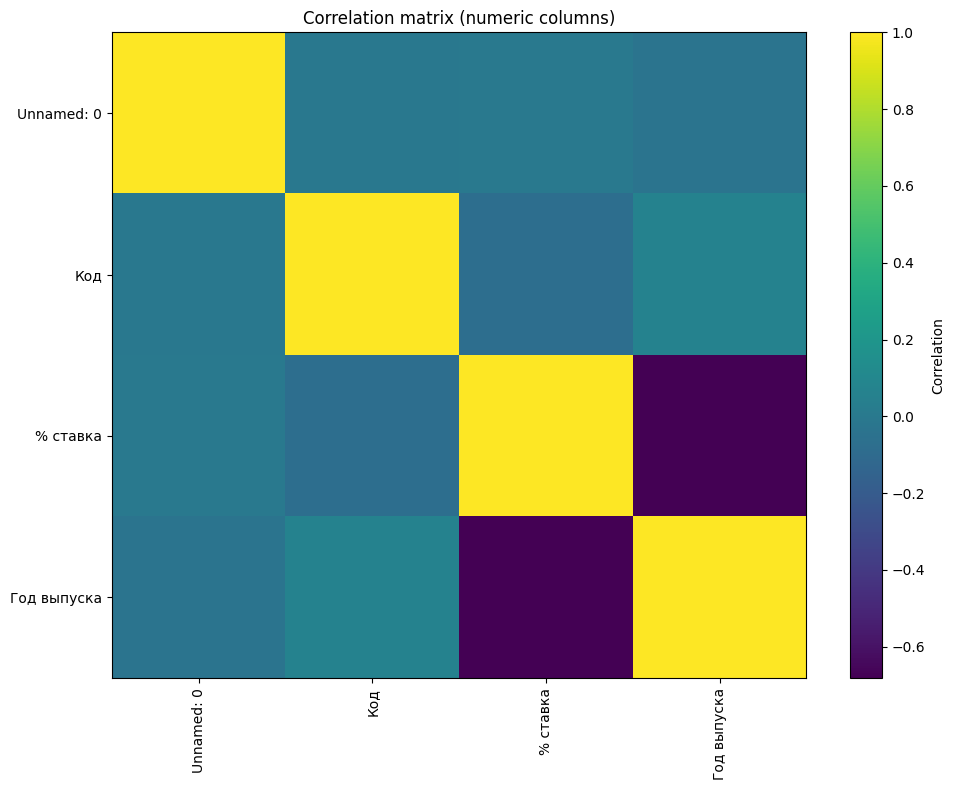

,Unnamed: 0,Код,% ставка,Год выпуска
Unnamed: 0,1.000,-0.008,-0.000,-0.032
Код,-0.008,1.000,-0.071,0.062
% ставка,-0.000,-0.071,1.000,-0.682
Год выпуска,-0.032,0.062,-0.682,1.000


In [11]:
num_df = {}
for c in num_cols:
    num_df[c] = as_numeric(df[c])
num_df = pd.DataFrame(num_df)

corr = num_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
plt.imshow(corr, interpolation="nearest", aspect="auto")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation matrix (numeric columns)")
plt.tight_layout()
plt.savefig(REPORTS_DIR / "correlation_matrix.png", dpi=150)
plt.show()

corr.round(3).head(12)


In [12]:
pairs = []
cols = corr.columns.tolist()
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        pairs.append((cols[i], cols[j], abs(corr.iloc[i, j]), corr.iloc[i, j]))
top_corr = (pd.DataFrame(pairs, columns=["col1","col2","abs_corr","corr"])
              .sort_values("abs_corr", ascending=False)
              .head(20))
top_corr


,col1,col2,abs_corr,corr
5,% ставка,Год выпуска,0.681636,-0.681636
3,Код,% ставка,0.070764,-0.070764
4,Код,Год выпуска,0.061762,0.061762
2,Unnamed: 0,Год выпуска,0.032068,-0.032068
0,Unnamed: 0,Код,0.008002,-0.008002
1,Unnamed: 0,% ставка,0.000323,-0.000323


In [13]:
cat_cols = []
for c in df.columns:
    if df[c].dtype == "object":
        uniq = df[c].nunique(dropna=True)
        if 1 < uniq <= min(50, max(10, len(df)//100)):  # heuristic
            cat_cols.append(c)

print("Candidate categorical columns:", cat_cols)


Candidate categorical columns: ['Облать', 'Облать(Фактичекий адрес)', 'Тип']


,value,count
0,АНДИЖОН ВИЛОЯТИ,489
1,НАМАНГАН ВИЛОЯТИ,2
2,ФАРГОНА ВИЛОЯТИ,1


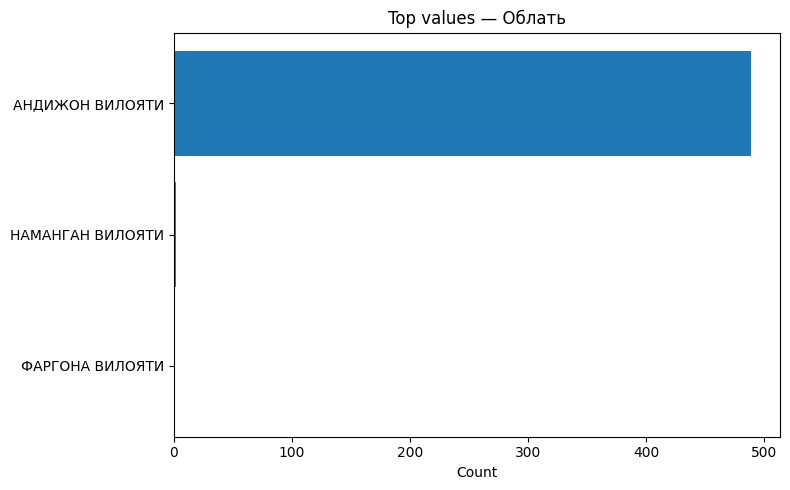

,value,count
0,АНДИЖОН ВИЛОЯТИ,489
1,НАМАНГАН ВИЛОЯТИ,2
2,ФАРГОНА ВИЛОЯТИ,1


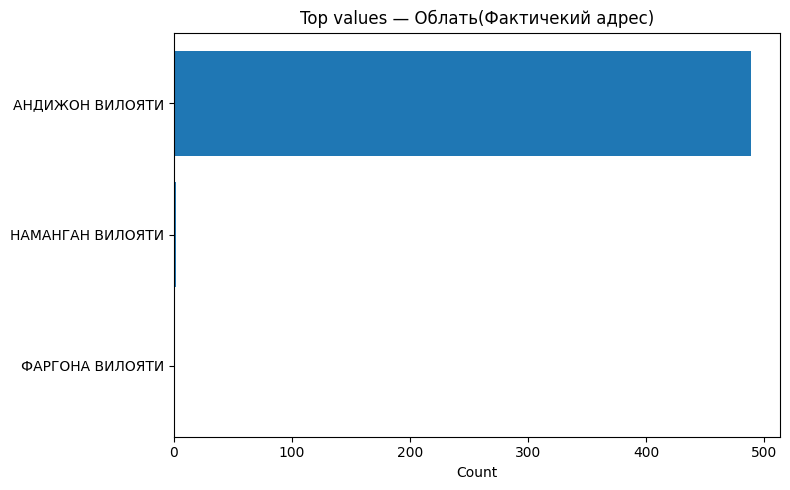

,value,count
0,Легковые автомобили,474
1,Грузовые автомобили и автобусы,17
2,Сельскохозяйственная техника,1


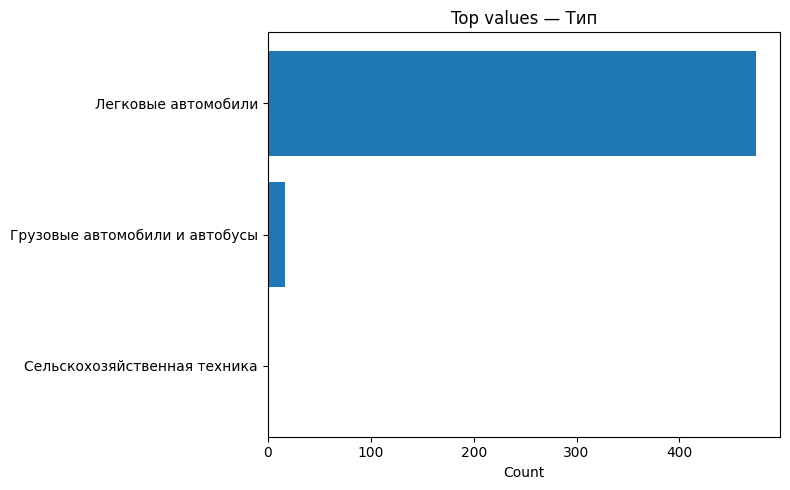

In [14]:
max_cats = 12
for i, c in enumerate(cat_cols[:max_cats], 1):
    vc = df[c].value_counts(dropna=False).head(20)
    display(pd.DataFrame({"value": vc.index.astype(str), "count": vc.values}))

    plt.figure(figsize=(8, 5))
    plt.barh(vc.index.astype(str)[::-1], vc.values[::-1])
    plt.title(f"Top values — {c}")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / f"value_counts_{i:02d}_{c}.png", dpi=120)
    plt.show()


In [15]:
totals = {}
for c in num_cols:
    totals[c] = as_numeric(df[c]).sum(skipna=True)
main_metric = (pd.Series(totals).sort_values(ascending=False).index[0]
               if totals else None)
main_metric


'Код'

,Облать,sum_Код
0,АНДИЖОН ВИЛОЯТИ,48497477188
1,НАМАНГАН ВИЛОЯТИ,198306141
2,ФАРГОНА ВИЛОЯТИ,99233154


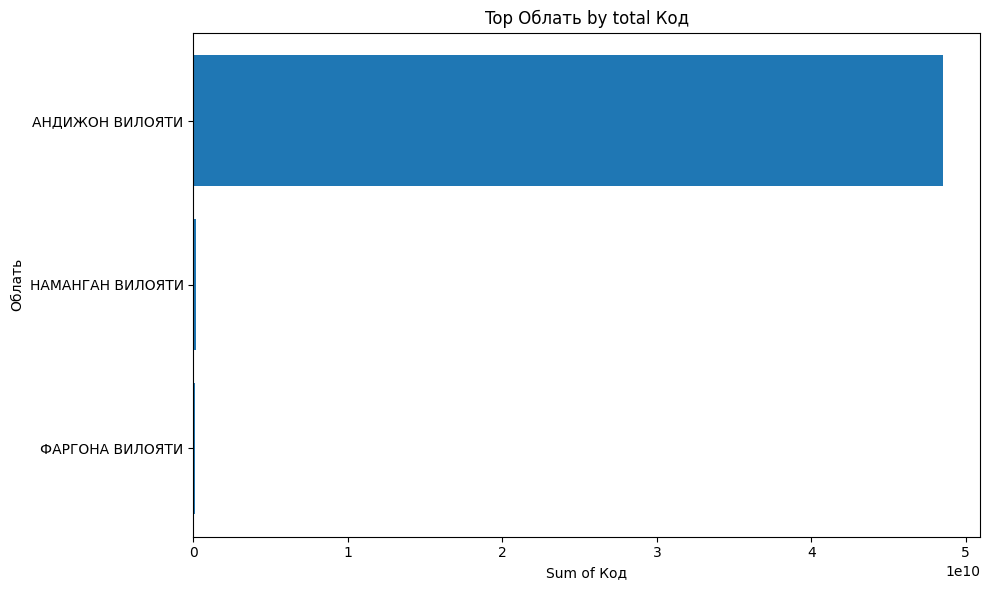

,Облать(Фактичекий адрес),sum_Код
0,АНДИЖОН ВИЛОЯТИ,48497477188
1,НАМАНГАН ВИЛОЯТИ,198306141
2,ФАРГОНА ВИЛОЯТИ,99233154


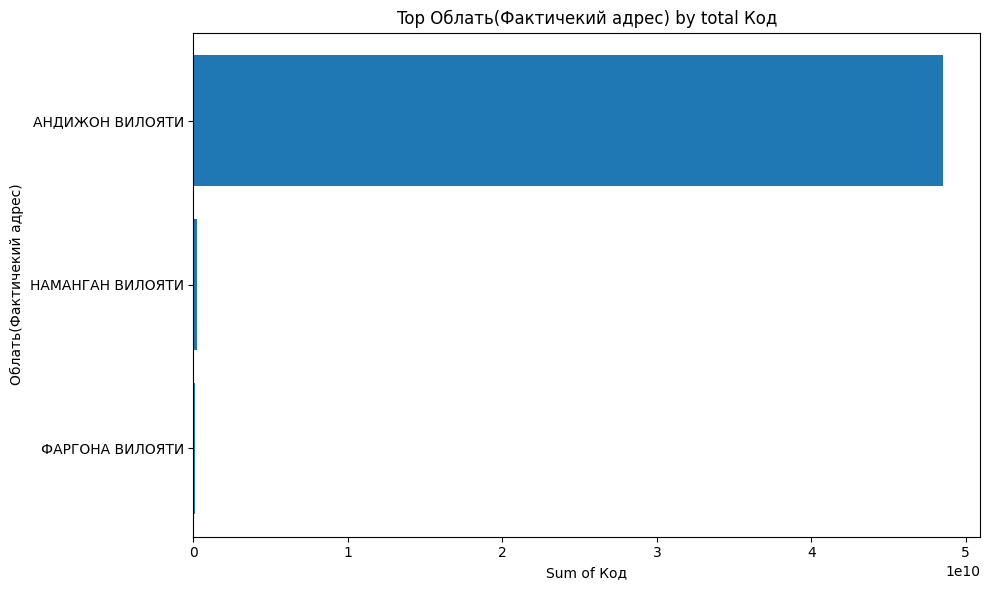

,Тип,sum_Код
0,Легковые автомобили,47010012084
1,Грузовые автомобили и автобусы,1685772210
2,Сельскохозяйственная техника,99232189


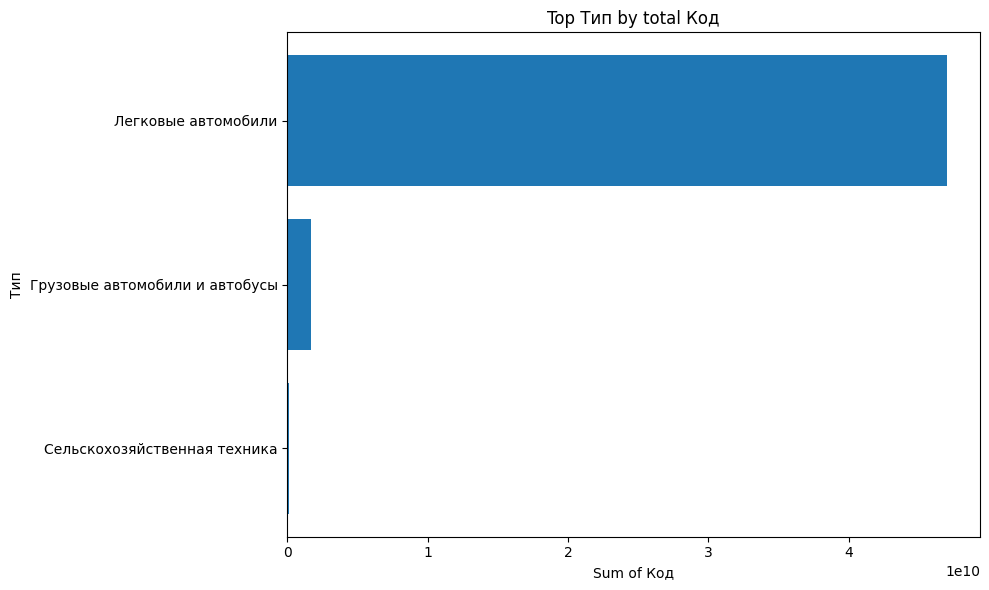

In [16]:
if main_metric is not None and len(cat_cols) > 0:
    for i, c in enumerate(cat_cols[:8], 1):
        g = (df.groupby(c, dropna=False)[main_metric]
               .apply(lambda s: as_numeric(s).sum(skipna=True))
               .sort_values(ascending=False).head(15))

        display(pd.DataFrame({c: g.index.astype(str), f"sum_{main_metric}": g.values}))

        plt.figure(figsize=(10, 6))
        plt.barh(g.index.astype(str)[::-1], g.values[::-1])
        plt.title(f"Top {c} by total {main_metric}")
        plt.xlabel(f"Sum of {main_metric}"); plt.ylabel(c)
        plt.tight_layout()
        plt.savefig(REPORTS_DIR / f"by_{c}_sum_{main_metric}.png", dpi=140)
        plt.show()


/tmp/ipykernel_91736/3311855151.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dates = pd.to_datetime(df[dcol], errors="coerce", dayfirst=True, infer_datetime_format=True)


,count
Дата,
2025-08,289
2025-09,203


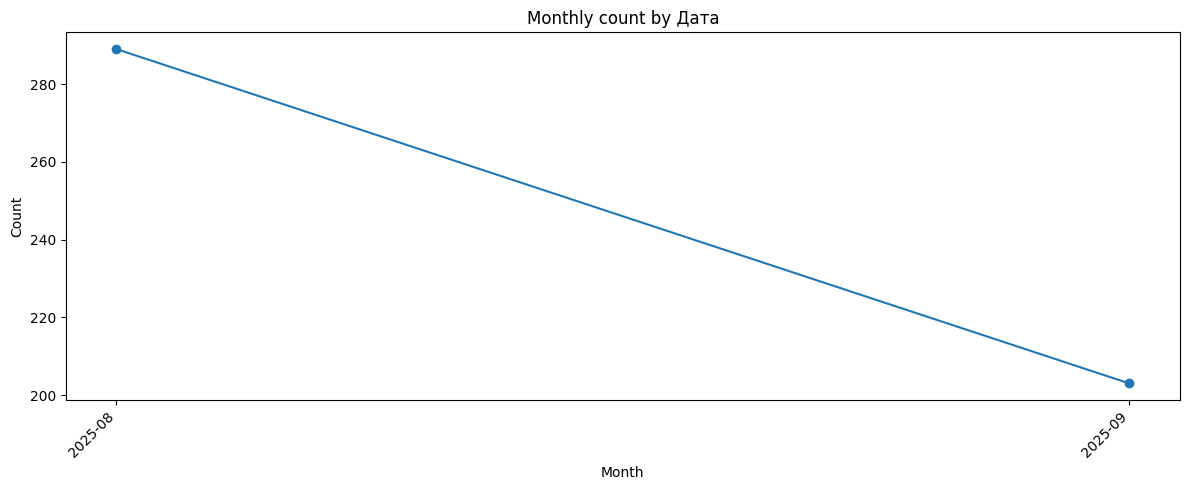

In [17]:
if len(date_cols) > 0:
    dcol = date_cols[0]
    dates = pd.to_datetime(df[dcol], errors="coerce", dayfirst=True, infer_datetime_format=True)

    monthly_counts = dates.dropna().dt.to_period("M").value_counts().sort_index()
    display(monthly_counts.to_frame("count").tail(24))

    plt.figure(figsize=(12, 5))
    idx = monthly_counts.index.astype(str)
    plt.plot(idx, monthly_counts.values, marker="o")
    plt.title(f"Monthly count by {dcol}")
    plt.xlabel("Month"); plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / f"monthly_count_{dcol}.png", dpi=150)
    plt.show()


/tmp/ipykernel_91736/1153952777.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dates = pd.to_datetime(df[dcol], errors="coerce", dayfirst=True, infer_datetime_format=True)


,sum_Код
month,
2025-08,28662571256
2025-09,20132445227


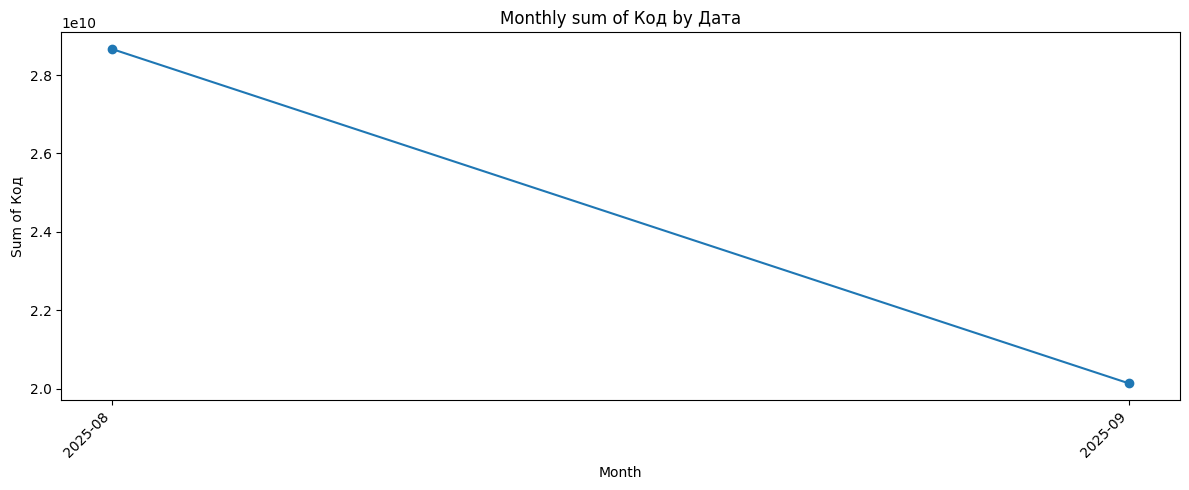

In [18]:
if len(date_cols) > 0 and main_metric is not None:
    dcol = date_cols[0]
    dates = pd.to_datetime(df[dcol], errors="coerce", dayfirst=True, infer_datetime_format=True)
    metric = as_numeric(df[main_metric])

    ts = (pd.DataFrame({"dt": dates, "metric": metric})
            .dropna(subset=["dt"])
            .assign(month=lambda x: x["dt"].dt.to_period("M"))
            .groupby("month")["metric"]
            .sum()
            .sort_index())

    display(ts.tail(24).to_frame(f"sum_{main_metric}"))

    plt.figure(figsize=(12, 5))
    idx = ts.index.astype(str)
    plt.plot(idx, ts.values, marker="o")
    plt.title(f"Monthly sum of {main_metric} by {dcol}")
    plt.xlabel("Month"); plt.ylabel(f"Sum of {main_metric}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / f"monthly_sum_{main_metric}.png", dpi=150)
    plt.show()


In [19]:
if main_metric is not None:
    metric = as_numeric(df[main_metric])
    deciles = pd.qcut(metric.rank(method="first"), 10, labels=[f"D{i}" for i in range(1,11)])
    bucket_tbl = (pd.DataFrame({"bucket": deciles, "metric": metric})
                    .groupby("bucket")["metric"].agg(["count","min","mean","median","max","sum"]))
    bucket_tbl


/tmp/ipykernel_91736/3672451766.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bucket")["metric"].agg(["count","min","mean","median","max","sum"]))


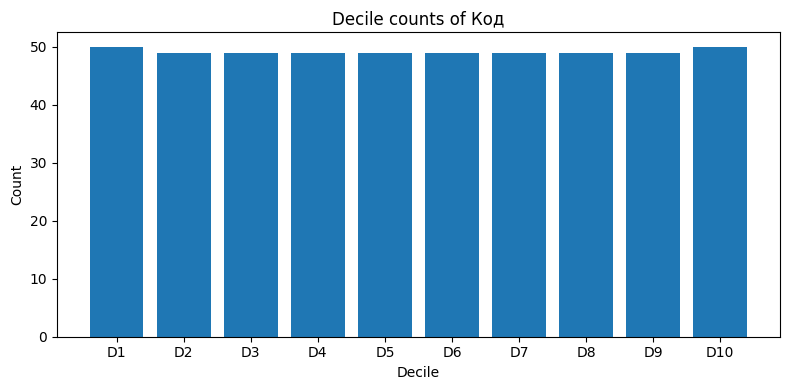

In [23]:
if main_metric is not None:
    metric = as_numeric(df[main_metric])
    deciles = pd.qcut(metric.rank(method="first"), 10, labels=[f"D{i}" for i in range(1,11)])
    s = (pd.DataFrame({"bucket": deciles})
           .value_counts()
           .sort_index())

    s = s.reset_index()
    s.columns = ["bucket", "count"]

    plt.figure(figsize=(8, 4))
    plt.bar(s["bucket"].astype(str), s["count"])
    plt.title(f"Decile counts of {main_metric}")
    plt.xlabel("Decile"); plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / f"deciles_{main_metric}.png", dpi=140)
    plt.show()


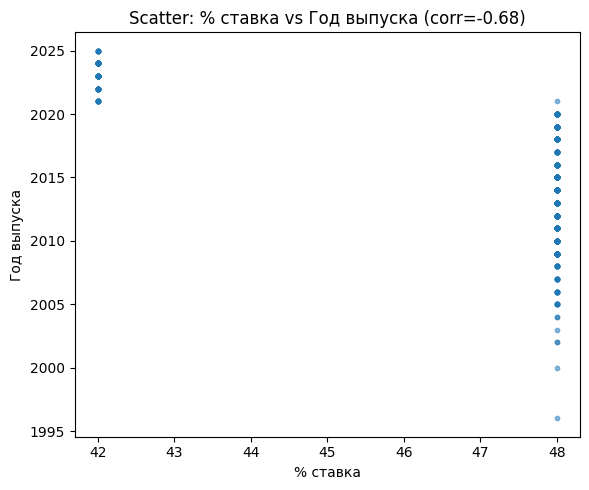

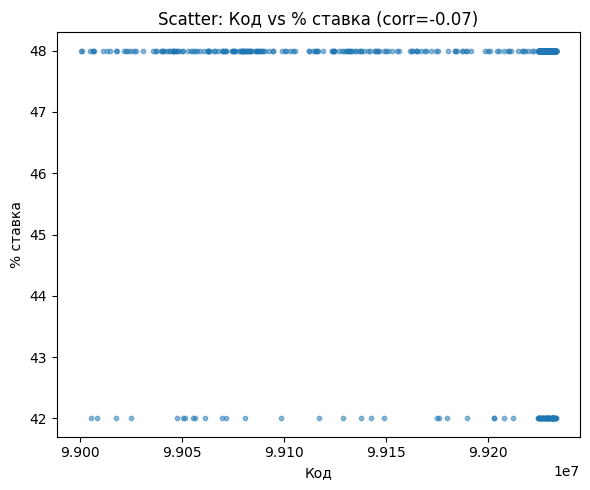

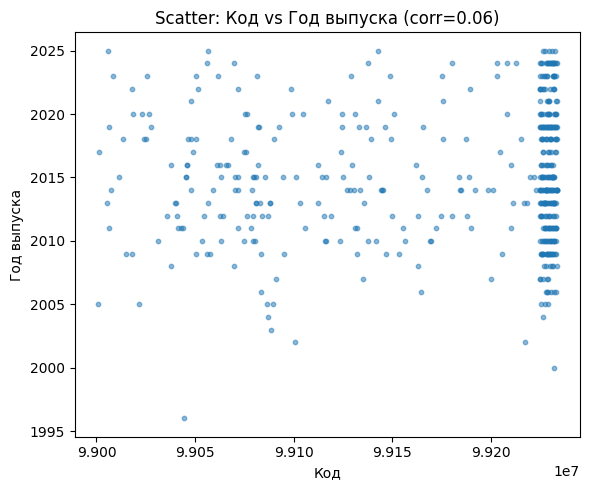

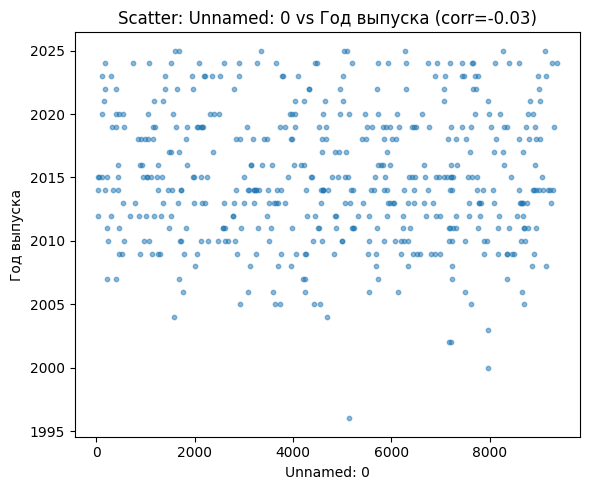

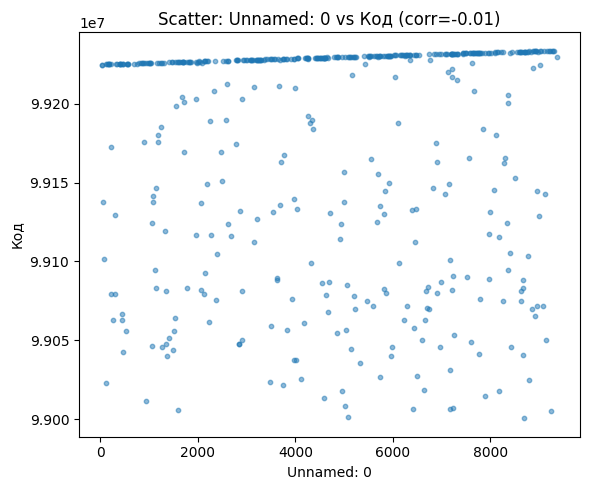

In [24]:
pairs_to_plot = top_corr.head(5) if 'top_corr' in globals() else pd.DataFrame()
for _, row in pairs_to_plot.iterrows():
    x, y = row["col1"], row["col2"]
    xv, yv = as_numeric(df[x]), as_numeric(df[y])

    plt.figure(figsize=(6, 5))
    plt.scatter(xv, yv, s=10, alpha=0.5)
    plt.title(f"Scatter: {x} vs {y} (corr={row['corr']:.2f})")
    plt.xlabel(x); plt.ylabel(y)
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / f"scatter_{x}_vs_{y}.png", dpi=130)
    plt.show()


In [25]:
numeric_summary.to_csv(REPORTS_DIR / "numeric_summary.csv")
missing.to_csv(REPORTS_DIR / "missingness.csv")
if 'top_corr' in globals() and not top_corr.empty:
    top_corr.to_csv(REPORTS_DIR / "top_correlations.csv", index=False)
print("Saved summary CSVs to reports/")


Saved summary CSVs to reports/
